In [1]:
!pip install -q -U arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.3 MB/s eta 0:00:00


In [2]:
import arxiv
import json

# Computation and Language (cs.CL)
# Machine Learning (cs.LG)
# Artificial Intelligence (cs.AI)

def search_causal_consistency(
    max_results: int = 200,
    page_size: int = 100,
    categories: tuple[str, ...] = ("cs.LG", "cs.AI", "cs.CL")
) -> str:
    # 1) Build the boolean query for "causal consistency"
    cat_clause   = " OR ".join(f"cat:{c}" for c in categories)
    query_string = f"({cat_clause}) AND (all:causal AND all:reasoning)"

    # 2) Define the Search (total results = max_results)
    search = arxiv.Search(
        query=query_string,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate,
        sort_order=arxiv.SortOrder.Descending
    )

    # 3) Initialize Client for pagination
    client = arxiv.Client(page_size=page_size, delay_seconds=3.0, num_retries=3)

    papers = []
    # 4) Page through using 'offset'
    for offset in range(0, max_results, page_size):
        for result in client.results(search, offset=offset):
            papers.append({
                "id":        result.entry_id.split("/")[-1],
                "title":     result.title,
                "abstract":  result.summary.replace("\n", " "),
                "published": result.published.isoformat(),
                "authors":   [str(a) for a in result.authors],
                "categories":result.categories,
                "pdf_url":   result.pdf_url
            })

    # 5) Return JSON string
    return json.dumps(papers, indent=2)


result_json = search_causal_consistency(max_results=300, page_size=100)

with open("causal_consistency_papers.json", "w") as out:
    out.write(result_json)

# Visualization

In [3]:
import pandas as pd

df=pd.DataFrame(json.loads(result_json))
df[:5]

,id,title,abstract,published,authors,categories,pdf_url
0,2504.16134v1,Multimodal Large Language Models for Enhanced ...,Traffic safety remains a critical global chall...,2025-04-21T18:48:35+00:00,"[Mohammad Abu Tami, Mohammed Elhenawy, Huthaif...","[cs.CV, cs.CL]",http://arxiv.org/pdf/2504.16134v1
1,2504.14530v1,Causality for Natural Language Processing,Causal reasoning is a cornerstone of human int...,2025-04-20T08:11:11+00:00,[Zhijing Jin],"[cs.CL, cs.AI, cs.CY, cs.LG]",http://arxiv.org/pdf/2504.14530v1
2,2504.14368v1,Do You Really Need Public Data? Surrogate Publ...,Differentially private (DP) machine learning o...,2025-04-19T17:55:10+00:00,"[Shlomi Hod, Lucas Rosenblatt, Julia Stoyanovich]","[cs.LG, cs.CR]",http://arxiv.org/pdf/2504.14368v1
3,2504.14150v1,Walk the Talk? Measuring the Faithfulness of L...,Large language models (LLMs) are capable of ge...,2025-04-19T02:51:20+00:00,"[Katie Matton, Robert Osazuwa Ness, John Gutta...","[cs.CL, cs.AI, cs.LG, stat.ML]",http://arxiv.org/pdf/2504.14150v1
4,2504.13717v1,"Human-aligned Deep Learning: Explainability, C...",This work aligns deep learning (DL) with human...,2025-04-18T14:40:58+00:00,[Gianluca Carloni],"[cs.CV, cs.AI, cs.LG, eess.IV, q-bio.NC, I.2; ...",http://arxiv.org/pdf/2504.13717v1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          600 non-null    object
 1   title       600 non-null    object
 2   abstract    600 non-null    object
 3   published   600 non-null    object
 4   authors     600 non-null    object
 5   categories  600 non-null    object
 6   pdf_url     600 non-null    object
dtypes: object(7)
memory usage: 32.9+ KB


/tmp/ipykernel_13/1957601692.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month']     = df['published'].dt.to_period('M')


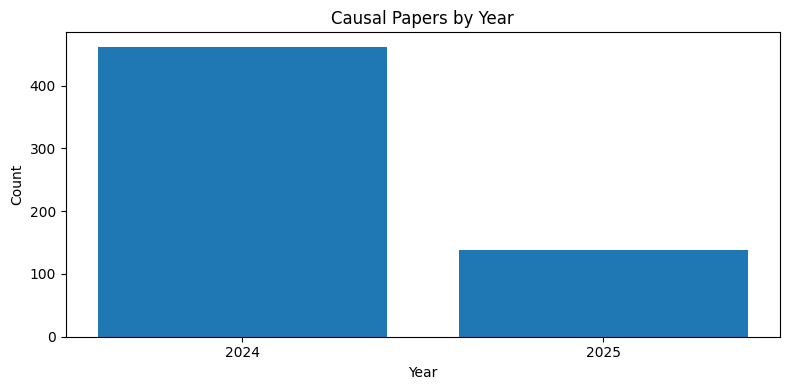

In [5]:
import matplotlib.pyplot as plt

df['published'] = pd.to_datetime(df['published'])
df['year']      = df['published'].dt.year
df['month']     = df['published'].dt.to_period('M')

# ──────────────────────────────────────────────────────────────────────────────
# 3) Plot: Number of papers per year
# ──────────────────────────────────────────────────────────────────────────────
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(8,4))
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.title('Causal Papers by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [6]:
from wordcloud import WordCloud, STOPWORDS

all_abstracts = " ".join(df['abstract'].dropna())
custom_stopwords = set(STOPWORDS) | {"paper", "study", "approach", "results", "using", "based"}

# Create word cloud
wordcloud = WordCloud(width=800,height=400,background_color='white',stopwords=custom_stopwords,min_font_size=10,max_words=100,colormap='viridis').generate(all_abstracts)

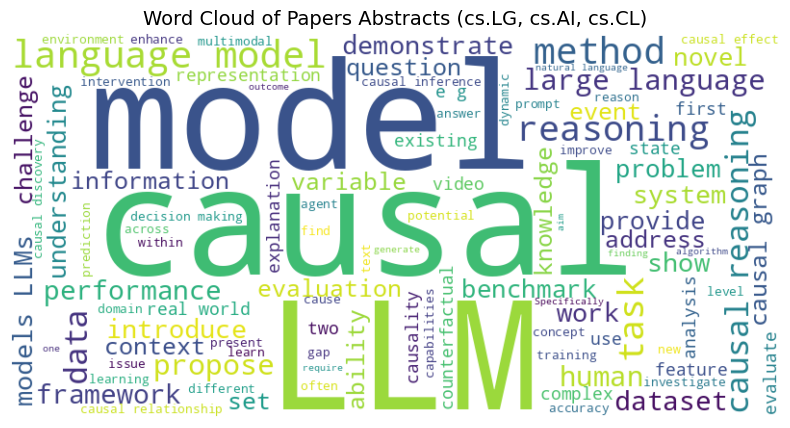

In [7]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Papers Abstracts (cs.LG, cs.AI, cs.CL)", fontsize=14)
plt.show()